# Analysis of Gender Wage Gap - DS 3001
## Michelle Kim, Michael McGeachy, Millie Pandya, Cara Seely

# Summary

For this project, our question of interest was what is the influence of age, education, and marital status upon the gender wage gap, as measured by income. This has been an area of increasing interest, and understanding its influencing factors is important for rectifying this disparity. We sourced data from the General Social Survey, and cleaned the corresponding data columns to facilitate our analysis, a process documented later in this paper. Final visualizations included a series of bar graphs and kernel density plots, coupled with statistical comparisons between the variables of interest and a baseline figure we computed to begin our analysis. To ensure thoroughness, each variable was broken down into each of its constituent categories to see where the wage gap was the most impactful. The age component demonstrated a general trend that younger professionals exhibited less of a gap than older age cohorts, at only 9% compared to a 19.8% baseline. Those that were either married, never married, or divorced also fared a smaller gap when compared to their separated or widowed counterparts. Finally, looking at education found the largest gap was found among the lowest levels of education, a trend that decreased as the level of education attained increased. Overall, those who are widowed, very old, or received the lowest education were found to suffer the most from the gender wage gap, with it being likely there is some overlap between the very old and widowed findings given the tendency for women to live longer than men.

# Data Cleaning

In [55]:
! git clone https://github.com/DS3001/project_gss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

fatal: destination path 'project_gss' already exists and is not an empty directory.


In [56]:
var_list = ['wrkstat', 'prestige'] # List of variables you want to save
output_filename = 'selected_gss_data.csv' # Name of the file you want to save the data to

modes = ['w','a'] # Has write mode and append mode
phase = 0 # Starts in write mode; after one iteration of loop, switches to append mode

for k in range(3): # for each chunk of the data
    url = 'https://github.com/DS3001/project_gss/raw/main/gss_chunk_' + str(1+k) + '.parquet' # Create url to the chunk to be processed
    #print(url) # Check the url is correct
    df = pd.read_parquet(url) # Download this chunk of data
    #print(df.head()) # Visually inspect the first few rows

    phase = 1 # Switch from write mode to append mode

print(df.shape)
df.columns
# 6694 columns/variables

(24130, 6694)


Index(['year', 'id', 'wrkstat', 'hrs1', 'hrs2', 'evwork', 'occ', 'prestige',
       'wrkslf', 'wrkgovt',
       ...
       'agehef12', 'agehef13', 'agehef14', 'hompoph', 'wtssps_nea',
       'wtssnrps_nea', 'wtssps_next', 'wtssnrps_next', 'wtsscomp',
       'wtsscompnr'],
      dtype='object', length=6694)

In [57]:
# Creating new data frame with certain, potentially relevant variables
df2 = df[['age', 'sex', 'race', 'degree', 'health', 'happy',
          'marital', 'martype', 'agewed', 'hrs2', 'indus10',
          'agekdbrn', 'childs', 'class', 'income16']]
#print(df2.dtypes, '\n')
print(df2.tail())
print(list(df2.columns))

#df2 = df.copy()
# age (N)
# sex (C) : male or female
# race (C)
# degree (C)
# health (C) : poor, fair, good, excellent
# happy (C) : level
# marital (C) : status
# martype (C) : type of marriage
# agewed (N) : age married
# wrkstat : part-time, full-time, school, keeping house
# hrs2 (N) : typical weekly hrs worked
# wrkslf (C) : self employed?
# wrkgovt1 (C) : government employeed
# wrkgovt2 (C) : private employeed
# whatslf2 (C) : work place classification
# ind10 (N) : work industry
# agekdbrn (N) : age when 1st kd born
# childs (N) : # of kids
# class (C) : economic (self-evaluated)
# income16 (N) : range total family income

        age     sex   race                    degree health         happy  \
24125  22.0  female  white               high school   good  pretty happy   
24126  29.0  female  white                  graduate   good  pretty happy   
24127  32.0    male  white  associate/junior college   good  pretty happy   
24128  49.0  female  white                  graduate   good    very happy   
24129  50.0    male  white                  graduate   fair  pretty happy   

             marital                             martype  agewed  hrs2  \
24125  never married                                 NaN     NaN   NaN   
24126        married                                 NaN     NaN   NaN   
24127  never married                                 NaN     NaN   NaN   
24128        married  marriage between a man and a woman     NaN   NaN   
24129        married  marriage between a man and a woman     NaN   NaN   

       indus10  agekdbrn  childs          class              income16  
24125   8660.0      

In [58]:
# Sex
df2['sex'] = df['sex'].apply(lambda x: x if x in ['male', 'female'] else pd.NA)

# Age - leave as is

# Race
df2['race'] = df['race'].apply(lambda x: x if x in ['white', 'black', 'other'] else pd.NA)


# Degree
df2['degree'] = df['degree'].apply(lambda x: x if x in ['high school', "bachelors",
                                                        'graduate', 'less than high school',
                                                        'associate/junior college'] else pd.NA)

# Health
df2['health'] = df['health'].apply(lambda x: x if x in ['poor', 'fair', 'excellent', 'good'] else pd.NA)


# Happy
df2['happy'] = df['happy'].apply(lambda x: x if x in ['very happy', 'pretty happy', 'not too happy'] else pd.NA)

# Marital
df2['marital'] = df['marital'].apply(lambda x: x if x in ['married', 'never married',
                                                          'divorced', 'widowed',
                                                          'separated'] else pd.NA)
df2.dropna(subset=['marital'], inplace=True)

# martype
df2['martype'] = df['martype'].apply(lambda x: x if x in ['marriage between a man and a woman',
                                                          'marriage between two people of the same gender'] else pd.NA)

# agewed - leave as is

# indus10
df2['indus10'] = pd.to_numeric(df2['indus10'], errors='coerce')
bins = [0, 3540, 4650, 5940, 7630, 9750, 9830, float('inf')]
labels = ['Management, Business, Science, and Arts Occupations', 'Service Occupations', 'Sales and Office Occupations',
          'Natural Resources, Construction, and Maintenance Occupations', 'Production, Transportation, and Material Moving Occupations',
          'Military Specific Occupations', 'Other']

df2['indus10'] = pd.cut(df2['indus10'], bins=bins, labels=labels, include_lowest=True, right=False)
#df2['indus10'] = df2['indus10'].fillna('Unemployed')


# hrs2 - leave as is

# Childs
df2['childs'] = df['childs'].apply(lambda x: x if x in [0.0, 2.0, 3.0, 1.0, 4.0, 5.0, 6.0, 8.0, 7.0] else pd.NA)

# Class
df2['class'] = df['class'].apply(lambda x: x if x in ['middle class', 'working class', 'lower class', 'upper class'] else pd.NA)

# agekdbrn - leave as is

# Income16
df2['income16'] = df['income16'].apply(lambda x: x if x in ['$60,000 to $74,999', '$170,000 or over', '$75,000 to $89,999', '$90,000 to $109,999',
                                                           '$50,000 to $59,999', '$40,000 to $49,999', '$110,000 to $129,999', '$30,000 to $34,999',
                                                            '$35,000 to $39,999', '$130,000 to $149,999', '$25,000 to $29,999', '$150,000 to $169,999',
                                                            '$10,000 to $12,499', '$22,500 to $24,999', '$20,000 to $22,499', '$12,500 to $14,999',
                                                            '$15,000 to $17,499', '$17,500 to $19,999', '$8,000 to $9,999', 'under $1,000',
                                                            '$1,000 to $2,999', '$3,000 to $3,999', '$7,000 to $7,999', '$5,000 to $5,999',
                                                            '$6,000 to $6,999', '$4,000 to $4,999'] else pd.NA)


<ipython-input-58-ea4df7860a43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sex'] = df['sex'].apply(lambda x: x if x in ['male', 'female'] else pd.NA)
<ipython-input-58-ea4df7860a43>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['race'] = df['race'].apply(lambda x: x if x in ['white', 'black', 'other'] else pd.NA)
<ipython-input-58-ea4df7860a43>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [59]:
for value, count in df2['indus10'].value_counts().items():
    print(f"{value}: {count} times")

nan_count = df2['indus10'].isna().sum()
print(f"nans:{nan_count}")

Production, Transportation, and Material Moving Occupations: 10705 times
Natural Resources, Construction, and Maintenance Occupations: 4615 times
Management, Business, Science, and Arts Occupations: 3967 times
Sales and Office Occupations: 2179 times
Service Occupations: 1337 times
Other: 70 times
Military Specific Occupations: 47 times
nans:1169


In [60]:
print(df2.tail())

        age     sex   race                    degree health         happy  \
24125  22.0  female  white               high school   good  pretty happy   
24126  29.0  female  white                  graduate   good  pretty happy   
24127  32.0    male  white  associate/junior college   good  pretty happy   
24128  49.0  female  white                  graduate   good    very happy   
24129  50.0    male  white                  graduate   fair  pretty happy   

             marital                             martype  agewed  hrs2  \
24125  never married                                 NaN     NaN   NaN   
24126        married                                 NaN     NaN   NaN   
24127  never married                                 NaN     NaN   NaN   
24128        married  marriage between a man and a woman     NaN   NaN   
24129        married  marriage between a man and a woman     NaN   NaN   

                                                 indus10  agekdbrn childs  \
24125  Producti

In [61]:
df2.to_csv('final_cleaned_data!.csv', index=False)

# Data Explanations
The following section explains the data cleaning choices that were made to facilitate our analysis. First pertains to the gender category, where only results that fell into the male/female gender dichotomy. The dataset initially included a broader spectrum of genders. With the gender wage gap as our research question, it was important to narrow down the data to responses that actually included this variable. Limiting the scope of the analysis with less data and genders was deemed necessary for the specificity of our research focus.

For the age variable, we made the choice to leave the original datasets division of ages into a series of age ranges, rather than singular specific values. With the broader range, we felt that the organization would be just as functional enough to analyze the research question.  Identifying the influence of age on wages was something we felt those existing divisions were sufficient for.

Regarding education, the choice was made to remove those that did not specify what level of education was attained. Coding these nonresponses as a separate variable was not considered appropriate given our lack of information, and removing them was needed to properly visualize the data later. We removed these empty entries to ensure that the analysis contains complete data.

To clean the marital status data, the team discounted the missing responses due to the inability for us to assume if they were unwed. The main input responses were kept as married, never married, separated, widowed, and divorced. The latter three responses indicate that the respondent is not married nor claiming marital status at the time of completing the survey. These categories for marital status were maintained, as they were appropriate for the analysis that followed.

Following the cleaning process, the data is better structured for analysis, with clearer categories and more consistent entries. In summary, the data cleaning process for this analysis involved thoughtful decisions on how to handle various variables, with a focus on aligning the dataset with the research question while addressing inconsistencies and gaps in the data. Each decision, from narrowing down the gender categories to consolidating marital status responses, was made with the intent to enhance the clarity and relevance of the data for exploring the gender wage gap.

# Results

## Reading the cleaned data file:

In [62]:
df = pd.read_csv('final_cleaned_data!.csv', low_memory=False)
print(df)

        age     sex   race                    degree     health         happy  \
0      48.0    male  white               high school       poor           NaN   
1      25.0    male  white                       NaN        NaN  pretty happy   
2      42.0    male  white                       NaN        NaN  pretty happy   
3      24.0    male  white               high school       good           NaN   
4      24.0  female  white                       NaN  excellent    very happy   
...     ...     ...    ...                       ...        ...           ...   
24084  22.0  female  white               high school       good  pretty happy   
24085  29.0  female  white                  graduate       good  pretty happy   
24086  32.0    male  white  associate/junior college       good  pretty happy   
24087  49.0  female  white                  graduate       good    very happy   
24088  50.0    male  white                  graduate       fair  pretty happy   

             marital       

## Isolating out the variables we want to analyze, and checking the potential responses for each of them:

In [63]:
# We can first list all of the possible responses given for 'sex':
sex_responses = []
for response in df['sex']:
    if response not in sex_responses:
        sex_responses.append(response)
print(sex_responses)

['male', 'female', nan]


In [64]:
# We can repeat this for marital status:
marriage_responses = []
for response in df['marital']:
    if response not in marriage_responses:
        marriage_responses.append(response)
print(marriage_responses)

['married', 'never married', 'divorced', 'separated', 'widowed']


In [65]:
# As well as education and income:
education_responses = []
for response in df['degree']:
    if response not in education_responses:
        education_responses.append(response)
print(education_responses)

income_responses = []
for response in df['income16']:
    if response not in income_responses:
        income_responses.append(response)
print(income_responses)

['high school', nan, 'associate/junior college', 'graduate', 'less than high school']
[nan, '$170,000 or over', '$50,000 to $59,999', '$75,000 to $89,999', '$60,000 to $74,999', '$30,000 to $34,999', 'under $1,000', '$8,000 to $9,999', '$12,500 to $14,999', '$40,000 to $49,999', '$5,000 to $5,999', '$35,000 to $39,999', '$25,000 to $29,999', '$90,000 to $109,999', '$22,500 to $24,999', '$20,000 to $22,499', '$110,000 to $129,999', '$150,000 to $169,999', '$130,000 to $149,999', '$1,000 to $2,999', '$17,500 to $19,999', '$6,000 to $6,999', '$10,000 to $12,499', '$15,000 to $17,499', '$7,000 to $7,999', '$3,000 to $3,999', '$4,000 to $4,999']


This information can also be found in the codebook, but it is important to check that the data post-cleaning is what we expect.

## Replacing the non-numerical values for income with numerical values:

In [66]:
# Replacing the string based income values with numbers to make plotting and analysis easier:
# (For each income range given, we are converting it to its mean value)
# This has potential issues; for example, the "$170,000 or over" bucket is being lumped into an income
# of $170,000; this will make mean values of the income quantitatively inaccurate, but comparisons for the
# sake of the gender pay gap should still hold.

df = df.replace('unemployed/zero income', 0)
df = df.replace('$170,000 or over', 170000)
df = df.replace('$50,000 to $59,999', 55000)
df = df.replace('$75,000 to $89,999', 82500)
df = df.replace('$60,000 to $74,999', 67500)
df = df.replace('$30,000 to $34,999', 32500)
df = df.replace('under $1,000', 500)
df = df.replace('$8,000 to $9,999', 9000)
df = df.replace('$12,500 to $14,999', 13750)
df = df.replace('$40,000 to $49,999', 45000)
df = df.replace('$5,000 to $5,999', 5500)
df = df.replace('$35,000 to $39,999', 37500)
df = df.replace('$25,000 to $29,999', 27500)
df = df.replace('$90,000 to $109,999', 100000)
df = df.replace('$22,500 to $24,999', 23750)
df = df.replace('$20,000 to $22,499', 21250)
df = df.replace('$110,000 to $129,999', 120000)
df = df.replace('$150,000 to $169,999', 160000)
df = df.replace('$130,000 to $149,999', 140000)
df = df.replace('$1,000 to $2,999', 2000)
df = df.replace('$17,500 to $19,999', 18750)
df = df.replace('$6,000 to $6,999', 6500)
df = df.replace('$10,000 to $12,499', 11250)
df = df.replace('$15,000 to $17,499', 16250)
df = df.replace('$7,000 to $7,999', 7500)
df = df.replace('$3,000 to $3,999', 3500)
df = df.replace('$4,000 to $4,999', 4500)

# To verify the data cleaning above works
print(sorted(df['income16'].unique()))

[nan, 500.0, 2000.0, 3500.0, 4500.0, 5500.0, 6500.0, 7500.0, 9000.0, 11250.0, 13750.0, 16250.0, 18750.0, 21250.0, 23750.0, 27500.0, 32500.0, 37500.0, 45000.0, 55000.0, 67500.0, 82500.0, 100000.0, 120000.0, 140000.0, 160000.0, 170000.0]


## Making a plot and some preliminary analysis:

<Axes: xlabel='income16', ylabel='Density'>

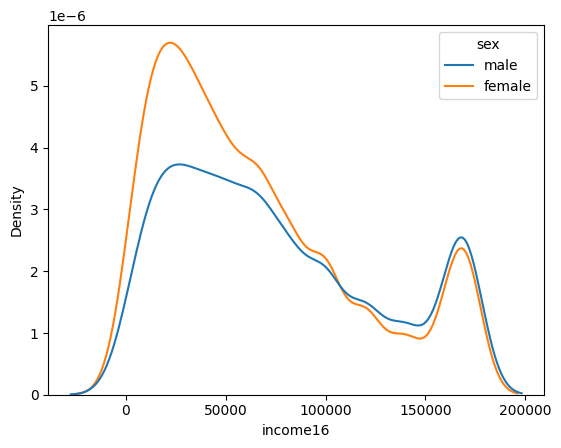

In [67]:
# First, we can see if the gender wage gap is immediately visible in a histogram:
sns.kdeplot(data=df,x='income16',hue='sex')

It does appear that in the lower income percentile, the proportion of females is greater; we can also quantify this by looking at some statistics regarding this data:

In [68]:
df.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                       \
          count          mean           std    min      25%      50%   
sex                                                                    
female   6156.0  64971.125731  49689.979662  500.0  23750.0  55000.0   
male     5169.0  75578.254982  51925.243015  500.0  32500.0  67500.0   

                            
             75%       max  
sex                         
female  100000.0  170000.0  
male    120000.0  170000.0

We see that the mean income for males is higher, by about 19.8%, which will serve as our baseline estimate of the gender pay gap that we compare to with further analysis.

## The impact of age on the gender wage gap:
To begin, we can see if any visual trends appear when creating a scatterplot of income levels and age, with hue determined by sex:

<Axes: xlabel='income16', ylabel='age'>

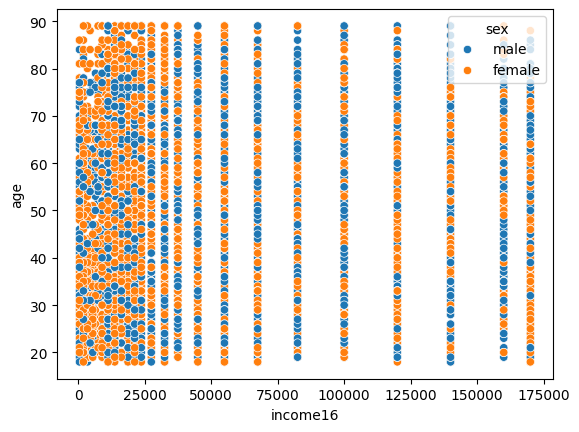

In [69]:
sns.scatterplot(data=df,x='income16',y='age',hue='sex')

This is not particularly illuminating, so we can first try separating age into four broad groups: "young" (below 35 years old), "middle-aged" (between 35 and 50 years old), "older" (between 50 and 70 years old), and "very old" (above 70 years old). Then, we can separate our earlier kernel density plot into four separate sets of statistics regarding the differences in income for the genders (this can also be done with a more finely-grained set of age groups):

In [70]:
df_young = df.loc[(df['age'] < 35)] # This is the dataframe we'll use for the "young" age category
# If the age doesn't fit with our "young" definition, we delete that row from this new dataframe.

<Axes: xlabel='income16', ylabel='Density'>

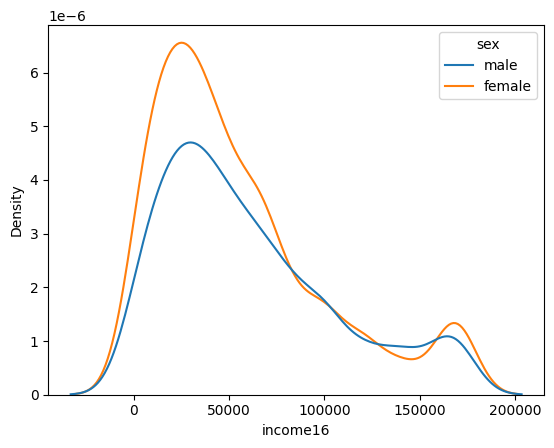

In [71]:
sns.kdeplot(data=df_young,x='income16',hue='sex')

In [72]:
df_young.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                                \
          count          mean           std    min      25%      50%      75%   
sex                                                                             
female   1455.0  55257.044674  45166.320069  500.0  21250.0  45000.0  67500.0   
male     1172.0  60976.322526  45858.939124  500.0  27500.0  45000.0  82500.0   

                  
             max  
sex               
female  170000.0  
male    170000.0

Here, we see that the income for males is only about 9.0% higher, lower than our baseline of 19.8% overall from earlier. We can hypothesize here that the gender wage gap is higher amongst older adults, and may have decreased over time due to increased efforts to educate the public and/or address the issue. We can test this with further analysis.

In [73]:
df_middleaged = df.loc[(df['age'] >= 35) & (df['age'] < 50)]
df_middleaged.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                       \
          count          mean           std    min      25%      50%   
sex                                                                    
female   1547.0  72933.904331  51881.258436  500.0  32500.0  67500.0   
male     1260.0  85996.031746  52085.534300  500.0  45000.0  82500.0   

                            
             75%       max  
sex                         
female  100000.0  170000.0  
male    120000.0  170000.0

In this category, we see that the income for males is about 19.9% higher than that for females, about equal to our baseline of 19.8% that we found earlier.

In [74]:
df_older = df.loc[(df['age'] >= 50) & (df['age'] < 70)]
df_older.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                       \
          count          mean           std    min      25%      50%   
sex                                                                    
female   2108.0  70286.053131  51391.102237  500.0  27500.0  55000.0   
male     1795.0  80043.593315  54914.307046  500.0  32500.0  67500.0   

                            
             75%       max  
sex                         
female  100000.0  170000.0  
male    120000.0  170000.0

Here, we see that the income for males is about 12.0% higher than that of females, lower than our baseline of 19.8% earlier. This is contrary to our hypothesis that the gender wage gap is higher at higher ages, but we will visually see the data more clearly in a bar graph later below. Before this, we can examine our "very old" group:

In [75]:
df_veryold = df.loc[(df['age'] >= 70)]
df_veryold.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                       \
          count          mean           std    min      25%      50%   
sex                                                                    
female    889.0  53174.915636  43371.123949  500.0  21250.0  37500.0   
male      814.0  69324.631450  47294.795678  500.0  32500.0  55000.0   

                            
             75%       max  
sex                         
female   67500.0  170000.0  
male    100000.0  170000.0

Here we find a much higher wage gap of about 60.0%, in line with our original hypothesis that the gender wage gap rises with age; however, there are other factors to consider here: for example, people aged higher than 70 may well have grown up in a time when there were fewer opportunities for women to enter the workforce for similar pay to men, and this may be a cause of the drastically high wage gap in this case.

We can also visually see the differences in gender pay gap based on age if we show a bar graph of the incomes of males and females at several different groups of ages:

<Axes: xlabel='agegroup', ylabel='income16'>

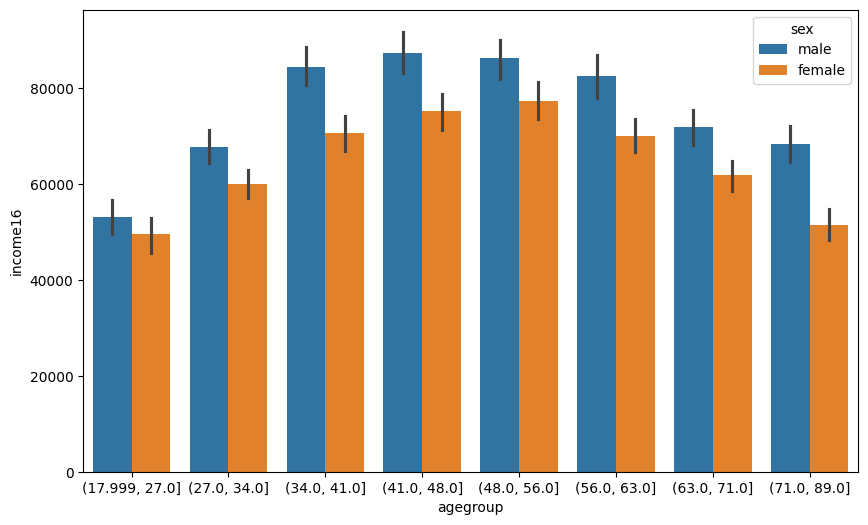

In [76]:
df['agegroup'] = pd.qcut(df['age'],8)
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.barplot(data=df,x='agegroup',y='income16',hue='sex',ax=ax)

Here, we see that the gender wage gap does broadly rise with age, though it decreases for a few of the age groups between 45 and 65, in line with what we observed from the statistics earlier.

## The impact of marital status on gender wage gap:
Here, since there are only a few different marital status groups, we can start by plotting a bar graph of income differences between males and females within groups of different marital statuses:

<Axes: xlabel='marital', ylabel='income16'>

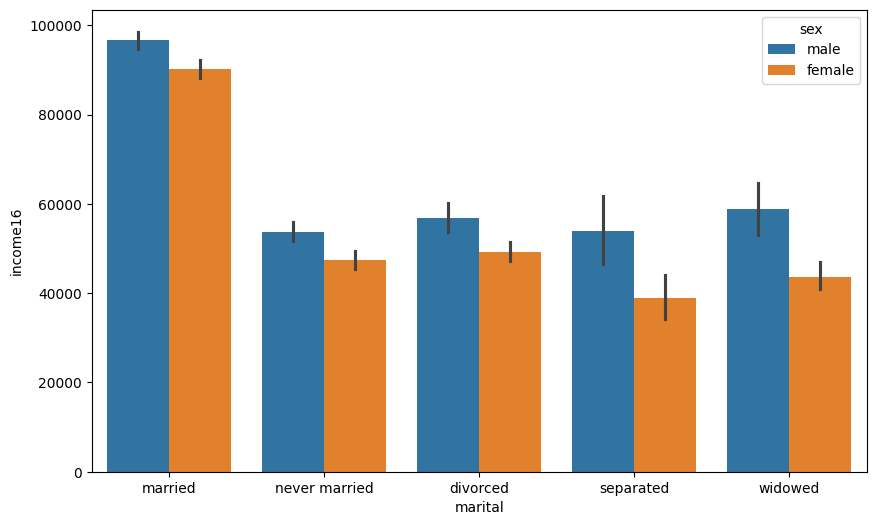

In [77]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.barplot(data=df,x='marital',y='income16',hue='sex',ax=ax)

Here, we see that the gender pay gap seems to be lower for married, never married, and divorced individuals compared to separated or widowed individuals. We can also examine numerical statistics for each of these groups, comparing the wage gap percentage to our overall baseline of 19.8% that we found earlier:

In [78]:
df_married = df.loc[(df['marital'] == 'married')]
df_married.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                        \
          count          mean           std    min      25%       50%   
sex                                                                     
female   2564.0  90254.875195  50009.491156  500.0  55000.0   82500.0   
male     2537.0  96710.287741  50489.893269  500.0  55000.0  100000.0   

                            
             75%       max  
sex                         
female  140000.0  170000.0  
male    140000.0  170000.0

In [79]:
print("MARRIED\n")
print("Percent difference: " + str(round((96710.287741 - 90254.875195)/90254.875195*100,1)) + "%")
print("Baseline: 19.8%")

MARRIED

Percent difference: 7.2%
Baseline: 19.8%


In [80]:
df_nevermarried = df.loc[(df['marital'] == 'never married')]
df_nevermarried.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                                \
          count          mean           std    min      25%      50%      75%   
sex                                                                             
female   1576.0  47459.390863  42215.649329  500.0  16250.0  35000.0  67500.0   
male     1493.0  53810.281313  44122.303855  500.0  21250.0  45000.0  67500.0   

                  
             max  
sex               
female  170000.0  
male    170000.0

In [81]:
print("NEVER MARRIED\n")
print("Percent difference: " + str(round((53810.281313 - 47459.390863)/47459.390863*100,1)) + "%")
print("Baseline: 19.8%")

NEVER MARRIED

Percent difference: 13.4%
Baseline: 19.8%


In [82]:
df_divorced = df.loc[(df['marital'] == 'divorced')]
df_divorced.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                                \
          count          mean           std    min      25%      50%      75%   
sex                                                                             
female   1201.0  49256.244796  40364.282150  500.0  18750.0  37500.0  67500.0   
male      772.0  56947.538860  44942.144684  500.0  21250.0  45000.0  82500.0   

                  
             max  
sex               
female  170000.0  
male    170000.0

In [83]:
print("DIVORCED\n")
print("Percent difference: " + str(round((56947.538860 - 49256.244796)/49256.244796*100,1)) + "%")
print("Baseline: 19.8%")

DIVORCED

Percent difference: 15.6%
Baseline: 19.8%


In [84]:
df_separated = df.loc[(df['marital'] == 'separated')]
df_separated.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                                \
          count          mean           std    min      25%      50%      75%   
sex                                                                             
female    214.0  38918.224299  37554.120191  500.0  13750.0  27500.0  55000.0   
male      121.0  53915.289256  43626.343744  500.0  21250.0  45000.0  67500.0   

                  
             max  
sex               
female  170000.0  
male    170000.0

In [85]:
print("SEPARATED\n")
print("Percent difference: " + str(round((53915.289256 - 38918.224299)/38918.224299*100,1)) + "%")
print("Baseline: 19.8%")

SEPARATED

Percent difference: 38.5%
Baseline: 19.8%


In [86]:
df_widowed = df.loc[(df['marital'] == 'widowed')]
df_widowed.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                                \
          count          mean           std    min      25%      50%      75%   
sex                                                                             
female    601.0  43706.322795  38490.554382  500.0  16250.0  32500.0  55000.0   
male      246.0  58878.048780  47177.188428  500.0  23750.0  45000.0  82500.0   

                  
             max  
sex               
female  170000.0  
male    170000.0

In [87]:
print("WIDOWED\n")
print("Percent difference: " + str(round((58878.048780 - 43706.322795)/43706.322795*100,1)) + "%")
print("Baseline: 19.8%")

WIDOWED

Percent difference: 34.7%
Baseline: 19.8%


Overall, we see that the gender wage gap is significantly higher than average for individuals that are separated and widowed. It is noteworthy, though, that the sample size of widowed men is significantly lower than that of widowed women; we know women tend to live longer than men, so this is to be expected, but this does also hint that there may be other extenuating factors that make this group have a particularly large wage gap, including the argument posed for the "very old" group from the previous section.

## The impact of education on gender wage gap:
Like in the previous section, since there are relatively few groups of education levels, we can begin with a bar graph to look for any visually apparent trends:

<Axes: xlabel='degree', ylabel='income16'>

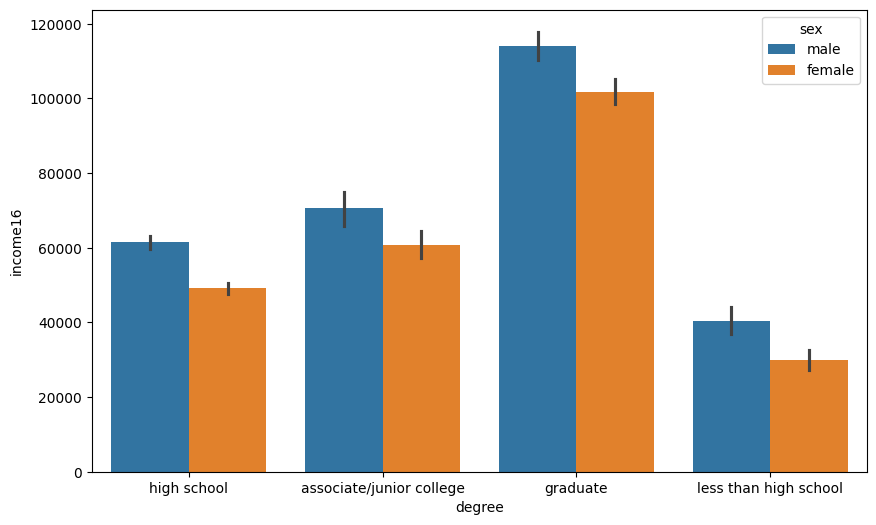

In [88]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.barplot(data=df,x='degree',y='income16',hue='sex',ax=ax)

From this, it appears that the gender wage gap may be lower for individuals with higher levels of education. As in the previous section, we can examine the statistics for each of these groups as well, comparing wage gap percentages to our baseline level:

In [89]:
df_highschool = df.loc[(df['degree'] == 'high school')]
df_highschool.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                                \
          count          mean           std    min      25%      50%      75%   
sex                                                                             
female   2762.0  49108.979001  40278.001354  500.0  18750.0  37500.0  67500.0   
male     2401.0  61477.613494  44370.976269  500.0  27500.0  55000.0  82500.0   

                  
             max  
sex               
female  170000.0  
male    170000.0

In [90]:
print("HIGH SCHOOL\n")
print("Percent difference: " + str(round((28240.399312 - 21460.088342)/21460.088342*100,1)) + "%")
print("Baseline: 19.8%")

HIGH SCHOOL

Percent difference: 31.6%
Baseline: 19.8%


In [91]:
df_bachelors = df.loc[(df['degree'] == "BACHELOR'S")]
df_bachelors.loc[:,['sex','income16']].groupby('sex').describe()

Empty DataFrame
Columns: [(income16, count), (income16, mean), (income16, std), (income16, min), (income16, 25%), (income16, 50%), (income16, 75%), (income16, max)]
Index: []

In [92]:
print("BACHELOR'S\n")
print("Percent difference: " + str(round((50684.967772 - 46760.514019)/46760.514019*100,1)) + "%")
print("Baseline: 19.8%")

BACHELOR'S

Percent difference: 8.4%
Baseline: 19.8%


In [93]:
df_associates = df.loc[(df['degree'] == "associate/junior college")]
df_associates.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                       \
          count          mean           std    min      25%      50%   
sex                                                                    
female    584.0  60672.517123  43214.063514  500.0  27500.0  55000.0   
male      417.0  70574.940048  47943.224902  500.0  32500.0  67500.0   

                            
             75%       max  
sex                         
female   82500.0  170000.0  
male    100000.0  170000.0

In [94]:
print("ASSOCIATE/JUNIOR COLLEGE\n")
print("Percent difference: " + str(round((37651.534527 - 29672.031773)/29672.031773*100,1)) + "%")
print("Baseline: 19.8%")

ASSOCIATE/JUNIOR COLLEGE

Percent difference: 26.9%
Baseline: 19.8%


In [95]:
df_graduate = df.loc[(df['degree'] == "graduate")]
df_graduate.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                         \
          count           mean           std    min      25%       50%   
sex                                                                      
female    910.0  101813.186813  51212.626146  500.0  55000.0  100000.0   
male      756.0  114111.772487  50781.285730  500.0  67500.0  120000.0   

                            
             75%       max  
sex                         
female  160000.0  170000.0  
male    170000.0  170000.0

In [96]:
print("GRADUATE\n")
print("Percent difference: " + str(round((64845.086272 - 58750.792644)/58750.792644*100,1)) + "%")
print("Baseline: 19.8%")

GRADUATE

Percent difference: 10.4%
Baseline: 19.8%


In [97]:
df_less = df.loc[(df['degree'] == "less than high school")]
df_less.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                                \
          count          mean           std    min      25%      50%      75%   
sex                                                                             
female    529.0  29930.529301  32856.840804  500.0   9000.0  21250.0  37500.0   
male      422.0  40473.933649  38084.010250  500.0  11250.0  27500.0  55000.0   

                  
             max  
sex               
female  170000.0  
male    170000.0

In [98]:
print("LESS THAN HIGH SCHOOL\n")
print("Percent difference: " + str(round((13651.158147 - 10357.514639)/10357.514639*100,1)) + "%")
print("Baseline: 19.8%")

LESS THAN HIGH SCHOOL

Percent difference: 31.8%
Baseline: 19.8%


Overall, we do see that the gender wage gap is highest for those with the lowest levels of education, and tends to decrease with increasing education. As backed up with the data, the graphs show how the wage gap changes across different education levels. Understanding this relationship between education and the gender wage gap is crucial for developing targeted strategies to address wage disparities and promote gender equality in the workplace.

## The Impact of Industry on Gender Wage Gap:

<ipython-input-99-0a2755e32595>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, rotation=45)


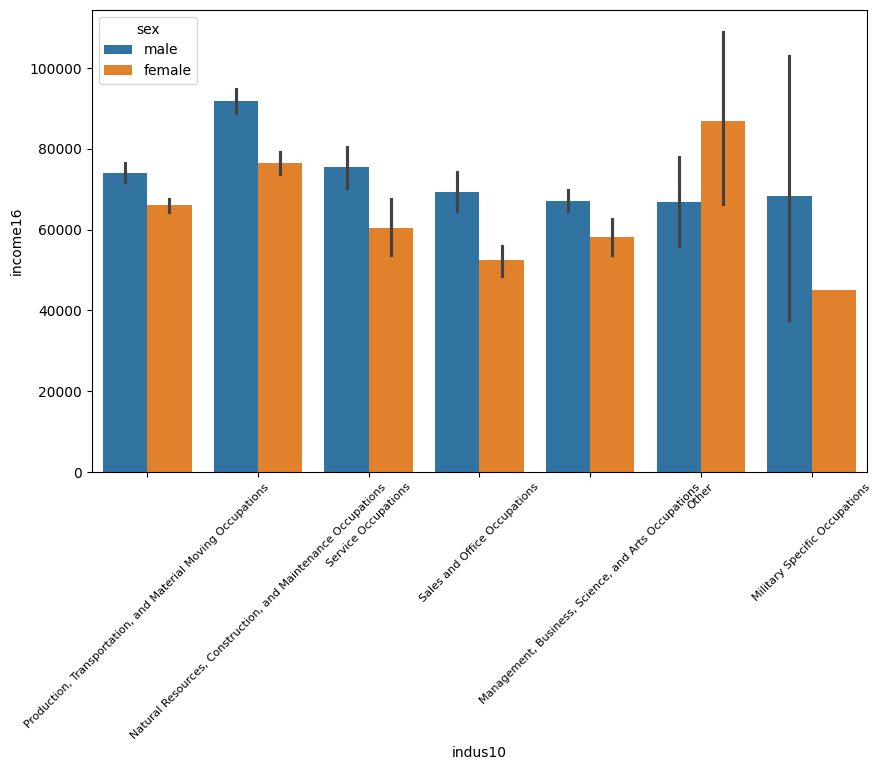

In [99]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.barplot(data=df,x='indus10',y='income16',hue='sex',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, rotation=45)

plt.show()

From the barplot, it is evident that the male gender tends to have a higher income across all industries with the exception of management, business, science, and arts occuptions. To analyze this further, let's look at the statistics

In [100]:
df_productionindus = df.loc[(df['indus10'] == "Production, Transportation, and Material Moving Occupations")]
df_productionindus.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                       \
          count          mean           std    min      25%      50%   
sex                                                                    
female   3436.0  66091.385332  49239.597960  500.0  27500.0  55000.0   
male     1731.0  73908.001155  51114.270638  500.0  32500.0  67500.0   

                            
             75%       max  
sex                         
female  100000.0  170000.0  
male    100000.0  170000.0

In [101]:
df_constructionindus = df.loc[(df['indus10'] == "Natural Resources, Construction, and Maintenance Occupations")]
df_constructionindus.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                       \
          count          mean           std    min      25%      50%   
sex                                                                    
female   1138.0  76564.806678  50371.088047  500.0  32500.0  67500.0   
male     1201.0  91743.130724  54243.324327  500.0  45000.0  82500.0   

                            
             75%       max  
sex                         
female  100000.0  170000.0  
male    140000.0  170000.0

In [102]:
df_salesindus = df.loc[(df['indus10'] == "Sales and Office Occupations")]
df_salesindus.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                       \
          count          mean           std    min      25%      50%   
sex                                                                    
female    567.0  52354.056437  44610.688076  500.0  18750.0  37500.0   
male      377.0  69251.326260  50626.602269  500.0  27500.0  55000.0   

                            
             75%       max  
sex                         
female   67500.0  170000.0  
male    100000.0  170000.0

In [103]:
df_managementindus = df.loc[(df['indus10'] == "Management, Business, Science, and Arts Occupations")]
df_managementindus.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                       \
          count          mean           std    min      25%      50%   
sex                                                                    
female    489.0  58146.216769  50320.553815  500.0  18750.0  45000.0   
male     1276.0  66968.847962  47745.391517  500.0  27500.0  55000.0   

                            
             75%       max  
sex                         
female   82500.0  170000.0  
male    100000.0  170000.0

In [104]:
df_militaryindus = df.loc[(df['indus10'] == "Military Specific Occupations")]
df_militaryindus.loc[:,['sex','income16']].groupby('sex').describe()

income16                                                              \
          count     mean           std      min      25%      50%       75%   
sex                                                                           
female      1.0  45000.0           NaN  45000.0  45000.0  45000.0   45000.0   
male        5.0  68250.0  42679.766869  11250.0  55000.0  55000.0  100000.0   

                  
             max  
sex               
female   45000.0  
male    120000.0

From the chart, it is apparent that males tend to earn more than females in essentially all occupational categories. The income disparity is visible across the board but varies in magnitude between different occupations.

The narrowest gaps appear in "Sales and Office Occupations" and "Service Occupations," where the bars are closer in height. The most substantial gaps are observable in "Management, Business, Science, and Arts Occupations" and "Military Specific Occupations," where the blue bars are noticeably taller than the orange bars. It is difficult to explain these disparities, as they are caused my multiple factors, including but not limited to: discrimination, work experience, education attainment, etc.

# Conclusion

This project aimed to analyze the factors that underpin the gender wage gap that much of society is familiar with, because by doing so it allows decision makers to target their interventions in the areas that actually matter. To accomplish this, variables around age, marital status, and education were chosen as factors that are often considered to be responsible for the disparity. The data for these was cleaned inorder to make analysis and visualizations more streamlined, with all changes being documented for future replication. Ultimately, a baseline difference of 19.8% was established, with subsequent analysis focusing on how that baseline related to more individualized comparisons. For age, the most notable finding was a difference of only 9% among our youngest comparison group, indicating that either progress has been made to shrink this gap or that wage disparities manifest later in life. This contrasted sharply with our findings in the very old category, demonstrating a difference of 60% that we hypothesized stemmed from women lacking many career options 70 years ago.

Next the analysis centered on marital status, which demonstrated that generally those who identified as married or never married were found to have the smallest wage gap between men and women. Divorcees exhibited a slightly smaller wage gap than those who are separated and widowed. This is indicative of women who have once been married facing the most income disparity, perhaps due to the consequential financial burden that comes with the loss of a partner. The smallest income gap occurring between married men and women may be due to society’s generally higher view of married women (as opposed to unmarried women) being more deserving of a higher-paying salary.

Finally, the focus shifted onto the role of education and its impact. Through this we found that the gap was the highest for the lowest levels of education and generally decreased as the level of education increased up to the graduate level. These findings lend credence to the idea that education can serve as an equalizer across demographic groups.

Despite what we consider to be extremely strong findings, we recognize that others will likely have criticism for various parts of the process. One area is undoubtedly the variables we included, as we did not consider the role of occupation, location, or the impact of children upon the wage gap. While these are all important factors, we ultimately decided to keep our analysis more focused as including all of those factors, with proper explanations, was outside of this project’s scope. Notably, we recognize that looking at the number of children would have shed more light onto the dynamics we hypothesized in the above section on marital status. There will also likely be criticism for focusing on a traditional, quantitative metric like income compared to the social well being indicators that have increased in popularity with time. While these SWB metrics are often touted as being more descriptive of someone’s true happiness, we regarded them as being both sufficient enough for an entirely separate study as well as being more non objective than the variables we were seeking.

By no means should our work be considered all encompassing, as the above section indicates the numerous other aspects that all play into the wage gap. Future work should focus on creating more localized datasets and carrying out a similar analysis to this one. As more information about the gender wage gap becomes common knowledge, it would be useful to track what cities/regions are doing a better job of countering it. This might also shed light into the underlying dynamics of a localized wage gap. Say if a town supported heavy industry that women did not work in, but instead filled a different job or the cost of living was low enough that they did not have to work as much. Understanding all of these dynamics is important for understanding the true impact of wage disparities. Another path for future work should focus on subjective well being, something that was discussed earlier in this paper. Income is not always the ultimate metric of someone’s life, and there are times when people are completely satisfied with their current situations and lifestyle. This too is important, as highlighting a wage disparity that is actually favored by its respondents should not hold the same weight as a situation where women are actively seeking better wages.
